In [1]:
import sklearn
from sklearn import linear_model
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import PyGnuplot as gp
import glob
import os
import random
import time 
sigma=3.504              #Parameters for LJ of Argon
kbT=0.010142612711

In [2]:
### Descriptor functions ###

# Lennard-Jones function
def LJ(r,sigma):
    return 4.0*((r/sigma)**(-12.0) - (r/sigma)**(-6.0))

# Gaussian Function
rcut=9
def Gauss(r,p,q):
    return np.exp(-p*(r-q)*(r-q))*0.5*(1+np.cos(np.pi*(r/rcut)))

list_Gauss=[]
for a in np.arange(0.5,2.5+0.001,0.25):
    for b in np.arange(2,10+0.001,0.5):
        list_Gauss=np.concatenate((list_Gauss,[a,b]))
list_Gauss=np.reshape(list_Gauss,(int(np.size(list_Gauss)/2),2))

list_LJ=[]
for a in np.arange(0.7,2+0.00001,0.02):
        list_LJ=np.concatenate((list_LJ,[a,1]))
list_LJ=np.reshape(list_LJ,(int(np.size(list_LJ)/2),2))

In [3]:
#### Read functions  #####
def readFile(input_file):
    Y=np.genfromtxt(input_file,invalid_raise=False, usecols=[5,6,7],dtype=float,skip_header=9)
    Y=Y.reshape(1, 3*np.shape(Y)[0])
    Y=Y[0]
    
    list_bin=[]
    for i_type in list_itype: 
        search=input_file[:-10]+"_f"+str(i_type)+"_*bin"
        search=search.replace("Input","Input_"+str(i_type))
        list_bin=np.append(list_bin,sorted(glob.glob(search)))
    
    XMAT=np.genfromtxt(list_bin[0])
    XMAT=np.transpose(XMAT)

        
    return(XMAT,Y) 

In [4]:
#Select the database

list_itype=['1']  
str_type=''
for i in range(np.size(list_itype)):
    str_type=str_type+list_itype[i]

In [5]:
#### Data reading #### 
list_files=sorted(glob.glob("Input/*.lammpstrj"))[::5]
N_files=np.size(list_files)
list_Train=sorted(random.sample(range(N_files),int(0.9*N_files)))   #Spliting between Train and Test
list_Test=sorted(np.delete(range(N_files),list_Train))
list_Train=[list_files[i] for i in list_Train]
list_Test=[list_files[i] for i in list_Test]

#Reading Train samples
print ("Training is done with")
input_file=list_Train[0]
XMAT_Train,Y_Train=readFile(input_file)
for input_file in list_Train[1:]: 
    print (input_file)
    XMAT_tmp,Y_tmp=readFile(input_file)
    XMAT_Train=np.concatenate((XMAT_Train,XMAT_tmp),axis=0)
    Y_Train=np.append(Y_Train,Y_tmp)

#Reading Test samples
print ("")
print ("Testing  is done with")
input_file=list_Test[0]
XMAT_Test,Y_Test=readFile(input_file)
for input_file in list_Test[1:]: 
    print (input_file)
    XMAT_tmp,Y_tmp=readFile(input_file)
    XMAT_Test=np.concatenate((XMAT_Test,XMAT_tmp),axis=0)
    Y_Test=np.append(Y_Test,Y_tmp)


Training is done with
Input/1_Liq.13.lammpstrj
Input/1_Liq.18.lammpstrj
Input/1_Liq.22.lammpstrj
Input/1_Liq.27.lammpstrj
Input/1_Liq.31.lammpstrj
Input/1_Liq.36.lammpstrj
Input/1_Liq.45.lammpstrj
Input/2_Crys.0.lammpstrj
Input/2_Crys.13.lammpstrj
Input/2_Crys.18.lammpstrj
Input/2_Crys.22.lammpstrj
Input/2_Crys.27.lammpstrj
Input/2_Crys.31.lammpstrj
Input/2_Crys.36.lammpstrj
Input/2_Crys.40.lammpstrj
Input/2_Crys.5.lammpstrj
Input/3_Clus.0.lammpstrj
Input/3_Clus.13.lammpstrj
Input/3_Clus.18.lammpstrj
Input/3_Clus.22.lammpstrj
Input/3_Clus.27.lammpstrj
Input/3_Clus.31.lammpstrj
Input/3_Clus.36.lammpstrj
Input/3_Clus.40.lammpstrj
Input/3_Clus.45.lammpstrj
Input/3_Clus.5.lammpstrj
Input/4_Def.0.lammpstrj
Input/4_Def.13.lammpstrj
Input/4_Def.18.lammpstrj
Input/4_Def.22.lammpstrj
Input/4_Def.27.lammpstrj
Input/4_Def.31.lammpstrj
Input/4_Def.36.lammpstrj
Input/4_Def.45.lammpstrj
Input/4_Def.5.lammpstrj

Testing  is done with
Input/1_Liq.5.lammpstrj
Input/2_Crys.45.lammpstrj
Input/4_Def.40.la

In [11]:
#### Fitting from Lasso to Ridge #### 
for ratio in (0.00,0.50,1.00):  #0.00=Ridge, 0.50=ElasticNet, 1.00=Lasso with coordinate descent
    clf =linear_model.ElasticNet(alpha=1e-6,l1_ratio=ratio,tol=0.01)
    clf.fit(XMAT_Train, Y_Train)
    coeff=np.copy(clf.coef_)
    
    # Score/RMSE/MAS
    Y_OUT_Train=clf.predict(XMAT_Train)
    Y_OUT_Test=clf.predict(XMAT_Test)
    scoreTrain=clf.score(XMAT_Train, Y_Train)
    scoreTest=clf.score(XMAT_Test, Y_Test)
    RMSE_Train=np.sqrt(mean_squared_error(Y_OUT_Train,Y_Train))
    RMSE_Test=np.sqrt(mean_squared_error(Y_OUT_Test,Y_Test))
    MAS_Train=mean_absolute_error(Y_OUT_Train,Y_Train)
    MAS_Test=mean_absolute_error(Y_OUT_Test,Y_Test)
    
    print (ratio, scoreTrain,scoreTest,RMSE_Train,RMSE_Test, sum(abs(coeff)>1E-10), np.size(coeff)) 

    output_file="Coeff"+str(ratio)+"_"+str_type+".txt"
    with open(output_file,'w') as fw:    
        for i in np.arange(np.size(coeff)):
            fw.write("%g %g\n"%(i,coeff[i]))

    output_file="ResultsTest"+str(ratio)+"_"+str_type+".txt"
    with open(output_file,'w') as fw:    
        for i in np.arange(np.size(Y_Test)):
            fw.write("%g %g %g \n"%(i,Y_Test[i],Y_OUT_Test[i]))
    
    output_file="ResultsTrain"+str(ratio)+"_"+str_type+".txt"
    with open(output_file,'w') as fw:    
        for i in np.arange(np.size(Y_Train)):
            fw.write("%g %g %g \n"%(i,Y_Train[i],Y_OUT_Train[i]))

0.0 0.989959145023949 0.9911875552995171 0.005478086238796966 0.00541253476765921 459 459
0.5 0.9914778989552777 0.9926912185558028 0.005046808864999116 0.004929183480784992 337 459
1.0 0.989542028130787 0.9909690523207071 0.005590713695336629 0.00547922531610995 331 459


In [12]:
#### Fitting with LassoLars #### 
clf =linear_model.LassoLars(1e-6)
clf.fit(XMAT_Train, Y_Train)
coeff=np.copy(clf.coef_)

# Score/RMSE/MAS
Y_OUT_Train=clf.predict(XMAT_Train)
Y_OUT_Test=clf.predict(XMAT_Test)
scoreTrain=clf.score(XMAT_Train, Y_Train)
scoreTest=clf.score(XMAT_Test, Y_Test)
RMSE_Train=np.sqrt(mean_squared_error(Y_OUT_Train,Y_Train))
RMSE_Test=np.sqrt(mean_squared_error(Y_OUT_Test,Y_Test))
MAS_Train=mean_absolute_error(Y_OUT_Train,Y_Train)
MAS_Test=mean_absolute_error(Y_OUT_Test,Y_Test)

print ("LassoLars", scoreTrain,scoreTest,RMSE_Train,RMSE_Test, sum(abs(coeff)>1E-10), np.size(coeff)) 


output_file="CoeffLassoLars.txt"
with open(output_file,'w') as fw:    
    for i in np.arange(np.size(coeff)):
        fw.write("%g %g\n"%(i,coeff[i]))

output_file="ResultsLassoLars_Test.txt"
with open(output_file,'w') as fw:    
    for i in np.arange(np.size(Y_Test)):
        fw.write("%g %g %g \n"%(i,Y_Test[i],Y_OUT_Test[i]))

output_file="ResultsLasso_Train.txt"
with open(output_file,'w') as fw:    
    for i in np.arange(np.size(Y_Train)):
        fw.write("%g %g %g \n"%(i,Y_Train[i],Y_OUT_Train[i]))
        
        

LassoLars 0.9914973705700169 0.9927692605193013 0.005041039999196506 0.004902796348029637 28 459


(459,)
153


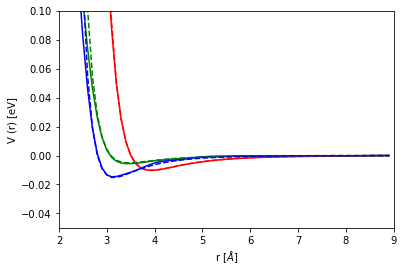

(459,)
153


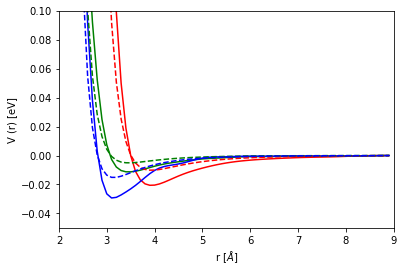

(459,)
153


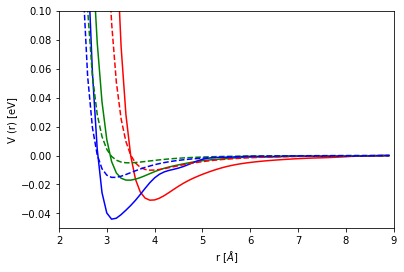

In [32]:
#### Plot from Ridge to Lasso #### 


r=np.arange(1,9,0.1)
V_AA=r*0
V_BB=r*0
V_AB=r*0


N_coeff=np.shape(list_Gauss)[0]
for ratio in (0.00,0.50,1.00):
    list_coeff=np.genfromtxt("Coeff"+str(ratio)+"_"+str_type+".txt",usecols=[1])
    print (np.shape(list_coeff))
    print (N_coeff)
    for i_coeff in np.arange(N_coeff):
        a=list_Gauss[i_coeff,0]
        b=list_Gauss[i_coeff,1]
        V_AA=V_AA+Gauss(r,a,b)*list_coeff[i_coeff]
    plt.plot(r,V_AA,"red")
    
    for i_coeff in np.arange(N_coeff):
        a=list_Gauss[i_coeff,0]
        b=list_Gauss[i_coeff,1]
        V_BB=V_BB+Gauss(r,a,b)*list_coeff[i_coeff+N_coeff]
    plt.plot(r,V_BB,"green")
    
    for i_coeff in np.arange(N_coeff):
        a=list_Gauss[i_coeff,0]
        b=list_Gauss[i_coeff,1]
        V_AB=V_AB+Gauss(r,a,b)*list_coeff[i_coeff+N_coeff*2]
    plt.plot(r,V_AB,"blue")
    
    plt.xlim([2,9 ])
    plt.ylim([-0.05,0.1 ])
    plt.xlabel('r [$\AA$]')
    plt.ylabel('V (r) [eV]')

    plt.plot(r,LJ(r,sigma)*kbT,'r--')
    plt.plot(r,LJ(r,sigma*0.88)*kbT*0.5,'g--')
    plt.plot(r,LJ(r,sigma*0.80)*kbT*1.5,'b--')
    plt.show()
    
    gp.s([r,V_AA,V_BB,V_AB])
    os.system("mv tmp.dat Out"+str(ratio)+"_"+str_type+".txt")
    
    

(459,)
153


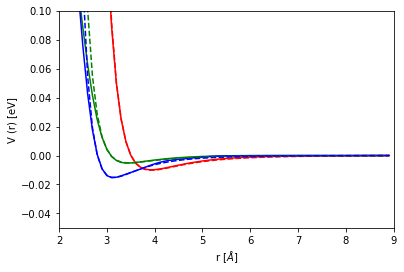

0

In [33]:
r=np.arange(1,9,0.1)
V_AA=r*0
V_BB=r*0
V_AB=r*0


N_coeff=np.shape(list_Gauss)[0]
list_coeff=np.genfromtxt("CoeffLassoLars.txt",usecols=[1])
print (np.shape(list_coeff))
print (N_coeff)
for i_coeff in np.arange(N_coeff):
    a=list_Gauss[i_coeff,0]
    b=list_Gauss[i_coeff,1]
    V_AA=V_AA+Gauss(r,a,b)*list_coeff[i_coeff]
plt.plot(r,V_AA,"red")

for i_coeff in np.arange(N_coeff):
    a=list_Gauss[i_coeff,0]
    b=list_Gauss[i_coeff,1]
    V_BB=V_BB+Gauss(r,a,b)*list_coeff[i_coeff+N_coeff]
plt.plot(r,V_BB,"green")

for i_coeff in np.arange(N_coeff):
    a=list_Gauss[i_coeff,0]
    b=list_Gauss[i_coeff,1]
    V_AB=V_AB+Gauss(r,a,b)*list_coeff[i_coeff+N_coeff*2]
plt.plot(r,V_AB,"blue")

plt.xlim([2,9 ])
plt.ylim([-0.05,0.1 ])
plt.xlabel('r [$\AA$]')
plt.ylabel('V (r) [eV]')

plt.plot(r,LJ(r,sigma)*kbT,'r--')
plt.plot(r,LJ(r,sigma*0.88)*kbT*0.5,'g--')
plt.plot(r,LJ(r,sigma*0.80)*kbT*1.5,'b--')
plt.show()

gp.s([r,V_AA,V_BB,V_AB])
os.system ('mv tmp.dat OutLasso.txt')


gp.s([r,LJ(r,sigma)*kbT,LJ(r,sigma*0.88)*kbT*0.5,LJ(r,sigma*0.80)*kbT*1.5])
os.system ('mv tmp.dat OutLJ.txt')


